## Project IMHOTEP
2022-02-04
This  notebook reads and plots river runoffs from NEMO outputs (annual-mean outputs) on top of SSS Std difference (GAI-S)

```
>> module load climate_science/
>> salloc --account cli@cpu --ntasks=1 --cpus-per-task=3 --partition=prepost --hint=nomultithread --time=00:30:00 srun --pty bash
>> idrlab  # to launch a jupyter server
```

Note: if partition preprost is temporary not available, just remove the option `--partition=prepost` (it will then run on the computing nodes - which are paid)


#### Import modules

In [1]:
## standart libraries

import os,sys
import numpy as np

# xarray
import xarray as xr

# plot
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cartopy.feature as cfeature

# custom tools for plotting
import lib_SLXtools_IMHOTEP_2021 as slx

import cmocean

# for jupyter notebook display
%matplotlib inline

import pkg_resources


## Print  package version:

In [2]:
# list packages to be checked
root_packages = [
     'numpy', 
    'matplotlib', 'cartopy', 'cmocean']

# print versions, but check if package is imported first
for m in pkg_resources.working_set:
    if m.project_name.lower() in root_packages:
        print(f"{m.project_name}=={m.version}")

numpy==1.20.0
matplotlib==3.3.4
cmocean==2.0
Cartopy==0.18.0


## Read IMHOTEP data
* Where to access SSS and runoff data:

In [4]:
prefix = "eORCA025.L75-IMHOTEP"
nexp = "GAI"
nexpREF = "S"
varna = 'sornf'  # river runoff variable in NEMO
varna2 = 'sosaline' # surface salinity

# years to read data from:
y1='1980'
y2='2018'

fo="1y" # output frequency

#  input directory on store
diridref="/gpfsstore/rech/cli/rcli002/eORCA025.L75/"+prefix+"."+nexpREF+"-S/"
diridat="/gpfsstore/rech/cli/rcli002/eORCA025.L75/"+prefix+"."+nexp+"-S/"

# input directory on work
diri="/gpfswork/rech/cli/rcli002/eORCA025.L75/eORCA025.L75-I/"

# plot directory
diro="/gpfswork/rech/cli/regi915/PLT/feb2022/"

* read files:

In [5]:
# read grid files
tmask = xr.open_dataset(diri+'mesh_hgr.nc')['tmask'][0,0,:,:]
e1    = xr.open_dataset(diri+'mesh_hgr.nc')['e1t'][0,:,:]
e2    = xr.open_dataset(diri+'mesh_hgr.nc')['e2t'][0,:,:]
nav_lon = xr.open_dataset(diri+'mesh_hgr.nc')['nav_lon']
nav_lat = xr.open_dataset(diri+'mesh_hgr.nc')['nav_lat']

# ======== RNF (runoffs)
# file list
rnffiles = diridat+fo+"/????/"+prefix+"."+nexp+"*flxT.nc"

# read data we read  from year y1 to y2
rnf1y = xr.open_mfdataset(rnffiles,concat_dim='time_counter',decode_times=True)[varna].sel(time_counter=slice(y1,y2))


#======== SSS (Salinity)
# file list
sssfiles = diridat+fo+"/????/"+prefix+"."+nexp+"*gridTsurf.nc"
sssfilesREF = diridref+fo+"/????/"+prefix+"."+nexpREF+"*gridTsurf.nc"

# read data from year y1 to y2
sss1y = xr.open_mfdataset(sssfiles,concat_dim='time_counter',decode_times=True)[varna2].sel(time_counter=slice(y1,y2))
sss1y_ref = xr.open_mfdataset(sssfilesREF,concat_dim='time_counter',decode_times=True)[varna2].sel(time_counter=slice(y1,y2))


# Compute linear trend and remove it from yearly timeseries

In [7]:
# compute linear trend
xrtrends,xrorigins,years = slx.trpolyfit(sss1y,'yr')
xrtrends_ref,xrorigins_ref,years_ref = slx.trpolyfit(sss1y_ref,'yr')


# retrieve trend  timeseries
sss1y_tr = slx.trseries(xrtrends,xrorigins,years,sss1y.time_counter)
sss1y_ref_tr = slx.trseries(xrtrends_ref,xrorigins_ref,years_ref,sss1y_ref.time_counter)


# retrieve detrended timeseries
sss1y_dt = sss1y - sss1y_tr
sss1y_ref_dt = sss1y_ref - sss1y_ref_tr

# Compute difference in STD between GAI and S

In [9]:
STDsss1y_ref_dt = sss1y_ref_dt.std(dim='time_counter')
STDsss1y_dt = sss1y_dt.std(dim='time_counter')

DIFF = STDsss1y_dt - STDsss1y_ref_dt

# Quick and dirty plot of  RIVER RUNOFF data at a given year

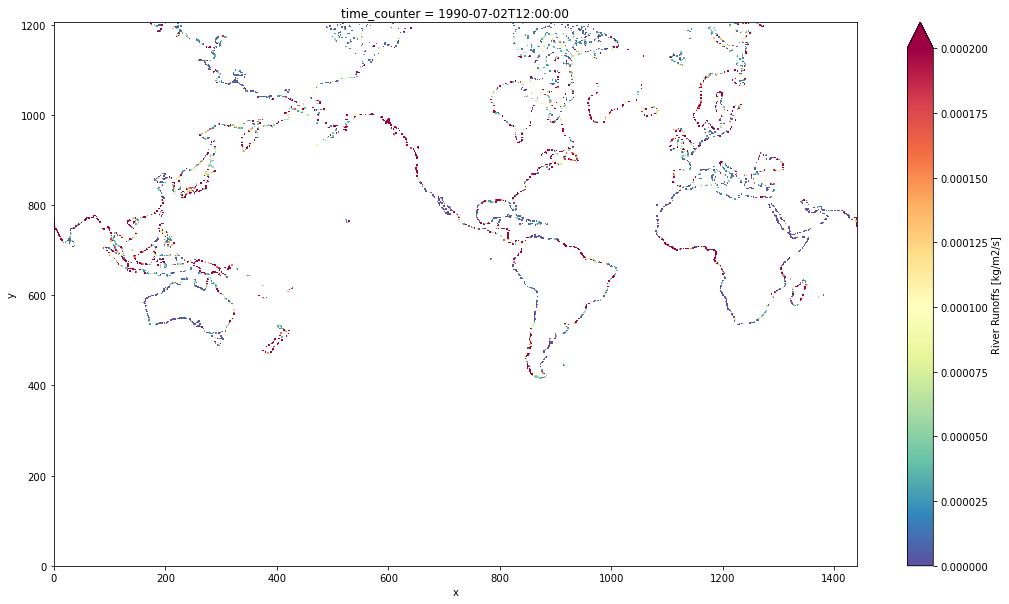

In [6]:
fig3 = plt.figure(figsize=([18,10]),facecolor='white')
rnf1y.isel(time_counter=10).plot(vmin=0, vmax=0.0002,cmap="Spectral_r")

# Time average of annual runoffs

In [11]:
rnf1y_1YAVE  = rnf1y.mean(dim='time_counter').load()

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


# Convert runoffs from kg/m2/s to m3/s

In [12]:
# annual mean
rnf1y_1YAVE_c = rnf1y_1YAVE
rnf1y_1YAVE_c = rnf1y_1YAVE_c*e1*e2   # e1*e2 is the area in m2 of the gridcell, so here we convert to  kg/s in each grid cell
rnf1y_1YAVE_c = rnf1y_1YAVE_c/1e3     # to convert kg/s to 1 ton/s  (and since 1 ton is the weight of 1 m3 of water, it is also converted in m3/s)
rnf1y_1YAVE_c.attrs['unit'] = "m3/s" 

# yearly timeseries
rnf1y_c = rnf1y
rnf1y_c = rnf1y_c*e1*e2 
rnf1y_c = rnf1y_c/1e3
rnf1y_c.attrs['unit'] = "m3/s" 


## quick and dirty plot at the mouth of the AMazon as a check

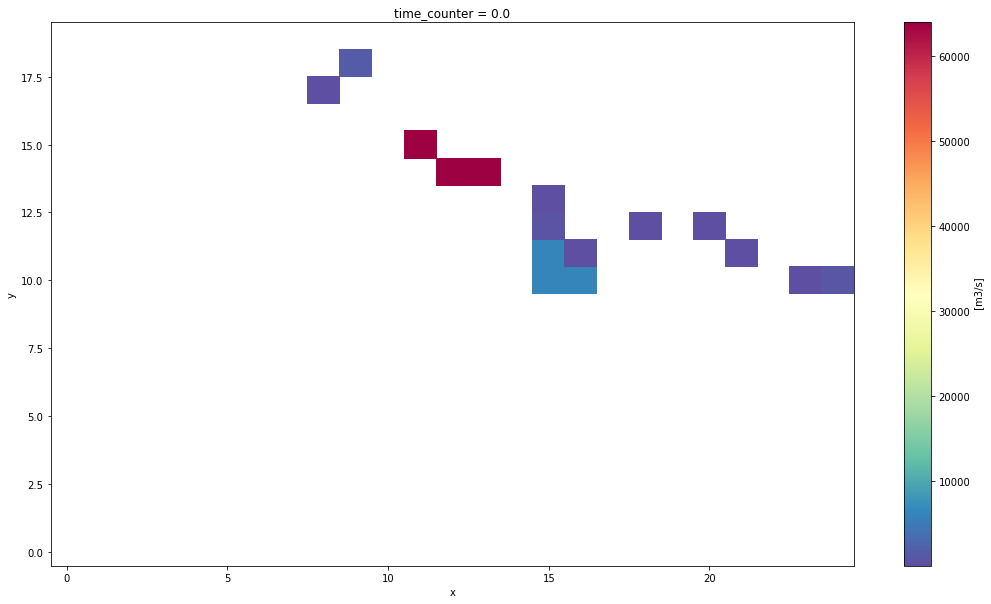

In [13]:
data2plot = rnf1y_1YAVE_c

fig3 = plt.figure(figsize=([18,10]),facecolor='white')
data2plot.isel(x=slice(940,965),y=slice(670,690)).plot(cmap="Spectral_r")

From the plot above, you see that there are 3 grid points were a runoff of \~63000 m3/s is applied, and 3 grid points with a runoff of \~7000 m3/s. In total, it's about __210 000m3/s which is consistent with the Amazon runoff__.

In [14]:
63000*3+7000*3

210000

# Highlight big  rivers on a map
highlight big rivers as circles of size proportional to runoffs  \+ runoffs shadded at gridpoints.

## stack runoff points in 1-d array and do the same for lat and lon arrays

In [15]:
rnf1y_1YAVE_stack=rnf1y_1YAVE_c.stack(z=("x", "y"))
nav_lat_stack = nav_lat.stack(z=("x", "y"))
nav_lon_stack = nav_lon.stack(z=("x", "y"))

## compute 95% and 98% runoff quantile (based on annual means)

In [16]:
rnf_nonzero = rnf1y_1YAVE_stack.where(rnf1y_1YAVE_stack>0.00,drop=True)

#quantile 95% high values
rnf95 = rnf_nonzero.quantile(0.95,dim='z')
print(rnf95.values)

print(rnf1y_1YAVE_stack.where(rnf1y_1YAVE_stack>rnf95.values,drop=True).count() )

#quantile 98% high values
rnf98 = rnf_nonzero.quantile(0.98,dim='z')
print(rnf98.values)

print(rnf1y_1YAVE_stack.where(rnf1y_1YAVE_stack>rnf98.values,drop=True).count() )

921.9127388800899
<xarray.DataArray ()>
array(222)
Coordinates:
    time_counter  float64 0.0
1798.6725749187103
<xarray.DataArray ()>
array(89)
Coordinates:
    time_counter  float64 0.0


## select runoff grid points higher than selected quantile (and do the same for lat lon corresponding coordinates)

In [17]:
qth='q95'
threshold = rnf95.values
rnfselect = rnf1y_1YAVE_stack.where(rnf1y_1YAVE_stack>threshold,drop=True)
latselect = nav_lat_stack.where(rnf1y_1YAVE_stack>threshold,drop=True)
lonselect = nav_lon_stack.where(rnf1y_1YAVE_stack>threshold,drop=True)

# for plot purposes, shift lon lat so that they are in the center of the gridpoint instead of on left side
latselect = latselect+0.125
lonselect = lonselect+0.125

# set magnitude for latter plot (magnitude relative to max runoff)
magnitude = (rnfselect.values)/(rnfselect.max().values)

## plot on map where runoffs are plotted at model gridpoints

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


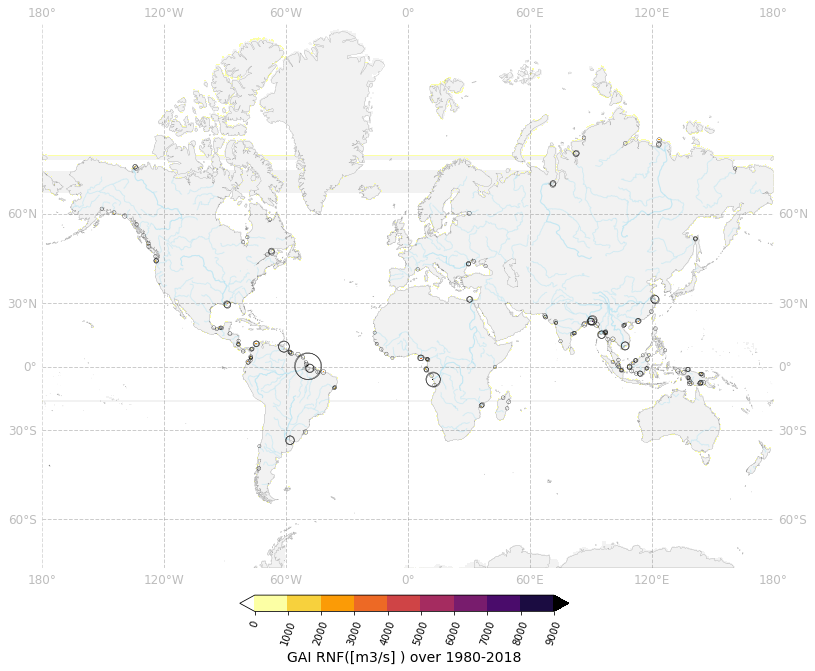

In [18]:
# REGION TO PLOT
reg='GLO'
iexp=nexp

# PLOT NAME
namo = "JZmap"+reg+"_RNF-"+qth+"_Yave_"+fo+"_"+iexp+"_"+y1+"-"+y2

#========= DATA TO PLOT

# main variable
if iexp==nexp:
    data2plot  = rnf1y_1YAVE_c.where(tmask!=0,0).squeeze()
    data2plot=data2plot

# lat lon
lon2plot   = nav_lon.squeeze()
lat2plot   = nav_lat.squeeze()
# land mask from model
m2plt      = tmask.where(tmask==0)


#========= Plot settings ===============
levbounds=[0.0,10e3,1e3]

# COLORMAP
co='in' # 
#add indication of colormap to the plot name:
namo = co+namo

# rgb color for model land grid points
r=242;g=242;b=242

# color for continents from data based (hi-res)
#onecohrml='#2E2E2E'
onecohrml='none'

# customed colormapls
if (co=='in'):
    cmap,norm = slx.mycolormap(levbounds,cm_base='inferno_r',cu='w',co='k')

# set grid params of  fig to plot
gridl,incrgridlon,incrgridlat,sath,minlat,maxlat,minlon,maxlon,loncentr,latcentr = slx.pltgridparam(reg=reg,gridl=False)


#================================================================
#========= CREATE FIGURE
fig3 = plt.figure(figsize=([18,10]),facecolor='white')

#========= PLOT DATA
# Data system proj (if coords are in lat lon, use PlateCarre here)
trdata  = ccrs.PlateCarree() 
if (reg=='GLO'):
    ax = plt.axes(projection= ccrs.Mercator(central_longitude=loncentr,min_latitude=minlat, max_latitude=maxlat, globe=None))
else:
    ax = plt.axes(projection= ccrs.NearsidePerspective(central_longitude=loncentr, central_latitude=latcentr,satellite_height=sath))
# plot data
cs  = plt.pcolormesh(lon2plot, lat2plot, data2plot,shading='flat',cmap=cmap,transform=trdata,norm=norm)

# add grey shading  where ocean mask is 0 (land gridpoints in the model)
# rgb color for model land grid points
cs2  = plt.pcolormesh(lon2plot, lat2plot, m2plt, shading='flat',cmap=slx.make_SLXcolormap(reverse=False,whichco='oneco',r=r,g=g,b=b),transform=trdata)


#========= GEOGRAPHICAL FEATURES
# make plot nice with rivers, continents, grids:
ax,gl = slx.pltaddfeatures(ax,incrgridlon,incrgridlat,onecohrml='none',reg=reg,landedgeco='#6E6E6E')  ##585858#BDBDBD

# add circles for the 5% higher runoffs
s1=plt.scatter(x=lonselect.values,
    y=latselect.values,
    alpha=1,
    s=magnitude*700,
    linewidths=0.3,
    marker='o',
    facecolors='none', 
    edgecolors='k',
    transform=trdata,
    cmap='inferno_r',
    zorder=20) 

#========= ADD COLORBAR
cbon=True
if cbon:
        tlabel=iexp+" RNF([m3/s] ) over "+y1+"-"+y2
        cb = slx.addcolorbar(fig3,cs,ax,levbounds,levincr=1,tformat="%.0f",
                             tlabel=tlabel,facmul=1,orientation='horizontal',tc='k',
                            bbta=(-0.18,-0.25,0.9,0.2))  


#========= PLT SHOW AND SAVE
plt.show()

# Save fig in png, resolution dpi    
slx.saveplt(fig3,diro,namo,dpifig=500)
plt.close(fig3)
    

## plot zoom on the equatorial atlantic 

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


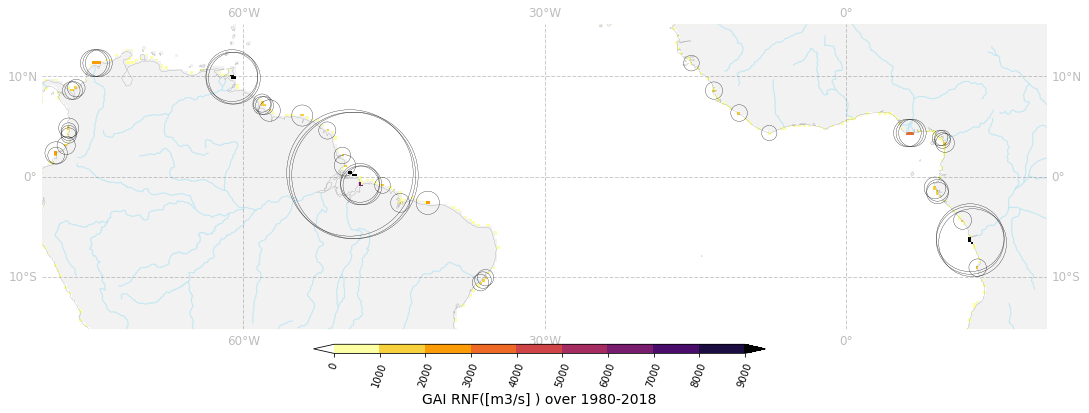

In [21]:
# REGION TO PLOT
reg='GLO'
iexp=nexp

# PLOT NAME
namo = "JZmapZOOM_RNF-"+qth+"_Yave_"+fo+"_"+iexp+"_"+y1+"-"+y2

#========= DATA TO PLOT

# main variable
if iexp==nexp:
    data2plot  = rnf1y_1YAVE_c.where(tmask!=0,0).squeeze()
    data2plot=data2plot

# lat lon
lon2plot   = nav_lon.squeeze()
lat2plot   = nav_lat.squeeze()
# land mask from model
m2plt      = tmask.where(tmask==0)

#========= Plot settings ===============
levbounds=[0.0,10e3,1e3]

# COLORMAP
co='in' # 
#add indication of colormap to the plot name:
namo = co+namo

# rgb color for model land grid points
r=242;g=242;b=242

# color for continents from data based (hi-res)
#onecohrml='#2E2E2E'
onecohrml='none'



# customed colormapls
if (co=='in'):
    cmap,norm = slx.mycolormap(levbounds,cm_base='inferno_r',cu='w',co='k')

# set grid params for future fig
gridl,incrgridlon,incrgridlat,sath,minlat,maxlat,minlon,maxlon,loncentr,latcentr = slx.pltgridparam(reg=reg,gridl=False)


#================================================================
#========= CREATE FIGURE
fig3 = plt.figure(figsize=([18,10]),facecolor='white')

#========= PLOT DATA
# Data system proj (if coords are in lat lon, use PlateCarre here)
trdata  = ccrs.PlateCarree() 
if (reg=='GLO'):
    ax = plt.axes(projection= ccrs.Mercator(central_longitude=loncentr,min_latitude=minlat, max_latitude=maxlat, globe=None))
else:
    ax = plt.axes(projection= ccrs.NearsidePerspective(central_longitude=loncentr, central_latitude=latcentr,satellite_height=sath))
# plot data
cs  = plt.pcolormesh(lon2plot, lat2plot, data2plot,shading='flat',cmap=cmap,transform=trdata,norm=norm)

# plot grey shading  where ocean mask is 0 (land gridpoints in the model)
# rgb color for model land grid points
cs2  = plt.pcolormesh(lon2plot, lat2plot, m2plt, shading='flat',cmap=slx.make_SLXcolormap(reverse=False,whichco='oneco',r=r,g=g,b=b),transform=trdata)


#========= GEOGRAPHICAL FEATURES
# make plot nice with rivers, continents, grids:
ax,gl = slx.pltaddfeatures(ax,30,10,onecohrml='none',reg=reg,landedgeco='#6E6E6E')  ##585858#BDBDBD

# add circles for the larger runoffs
s1=plt.scatter(x=lonselect.values,
    y=latselect.values,
    alpha=1,
    s=magnitude*16000,
    linewidths=0.3,
    marker='o',
    facecolors='none', 
    edgecolors='k',
    transform=trdata,
    cmap='inferno_r',
    zorder=20) 

ax.set_extent([-80, 20, -10, 10])

#========= ADD COLORBAR
cbon=True
if cbon:
        tlabel=iexp+" RNF([m3/s] ) over "+y1+"-"+y2
        cb = slx.addcolorbar(fig3,cs,ax,levbounds,levincr=1,tformat="%.0f",
                             tlabel=tlabel,facmul=1,orientation='horizontal',tc='k',
                            bbta=(-0.18,-0.25,0.9,0.2))  





#========= PLT SHOW AND SAVE
plt.show()

# Save fig in png, resolution dpi    
slx.saveplt(fig3,diro,namo,dpifig=500)
plt.close(fig3)
    

## zoom on the brazilian coast

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


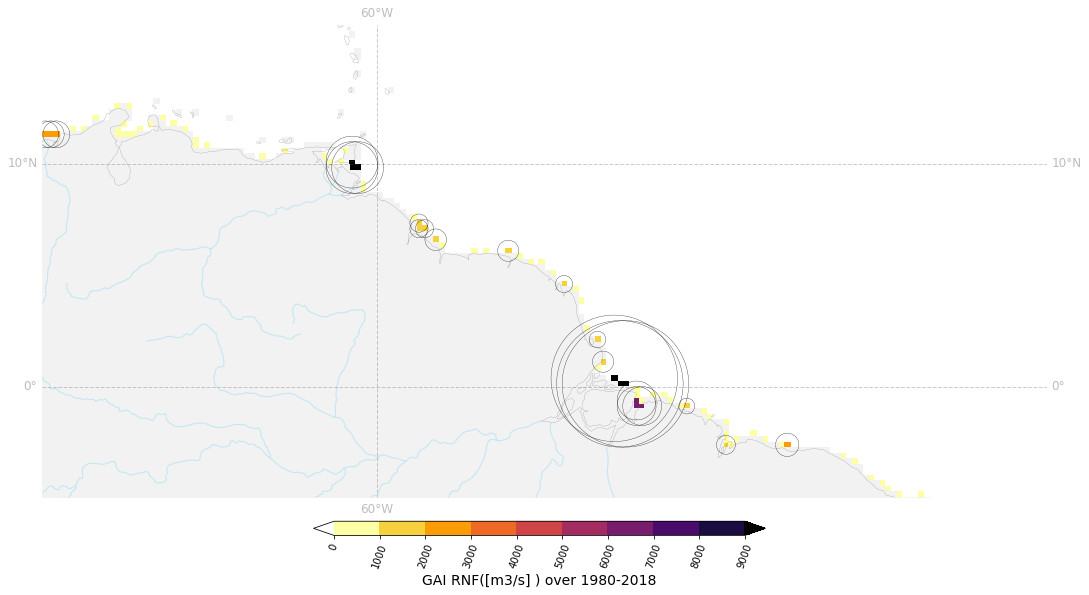

In [22]:
# REGION TO PLOT
reg='GLO'
iexp=nexp

# PLOT NAME
namo = "JZmapZOOM2_RNF-"+qth+"_Yave_"+fo+"_"+iexp+"_"+y1+"-"+y2

#========= DATA TO PLOT

# main variable
if iexp==nexp:
    data2plot  = rnf1y_1YAVE_c.where(tmask!=0,0).squeeze()
    data2plot=data2plot


# lat lon
lon2plot   = nav_lon.squeeze()
lat2plot   = nav_lat.squeeze()
# land mask from model
m2plt      = tmask.where(tmask==0)



#========= Plot settings ===============
levbounds=[0.0,10e3,1e3]

# COLORMAP
co='in' # 
#add indication of colormap to the plot name:
namo = co+namo

# rgb color for model land grid points
r=242;g=242;b=242


# color for continents from data based (hi-res)
#onecohrml='#2E2E2E'
onecohrml='none'



# customed colormapls
if (co=='in'):
    cmap,norm = slx.mycolormap(levbounds,cm_base='inferno_r',cu='w',co='k')

# set grid params for future fig
gridl,incrgridlon,incrgridlat,sath,minlat,maxlat,minlon,maxlon,loncentr,latcentr = slx.pltgridparam(reg=reg,gridl=False)


#================================================================
#========= CREATE FIGURE
fig3 = plt.figure(figsize=([18,10]),facecolor='white')

#========= PLOT DATA
# Data system proj (if coords are in lat lon, use PlateCarre here)
trdata  = ccrs.PlateCarree() 
if (reg=='GLO'):
    ax = plt.axes(projection= ccrs.Mercator(central_longitude=loncentr,min_latitude=minlat, max_latitude=maxlat, globe=None))
else:
    ax = plt.axes(projection= ccrs.NearsidePerspective(central_longitude=loncentr, central_latitude=latcentr,satellite_height=sath))
# plot data
cs  = plt.pcolormesh(lon2plot, lat2plot, data2plot,shading='flat',cmap=cmap,transform=trdata,norm=norm)

# plot grey shading  where ocean mask is 0 (land gridpoints in the model)
# rgb color for model land grid points
cs2  = plt.pcolormesh(lon2plot, lat2plot, m2plt, shading='flat',cmap=slx.make_SLXcolormap(reverse=False,whichco='oneco',r=r,g=g,b=b),transform=trdata)


#========= GEOGRAPHICAL FEATURES
# make plot nice with rivers, continents, grids:
ax,gl = slx.pltaddfeatures(ax,30,10,onecohrml='none',reg=reg,landedgeco='#6E6E6E')  ##585858#BDBDBD

# cirlces for the 5% larger runoffs
s1=plt.scatter(x=lonselect.values,
    y=latselect.values,
    alpha=1,
    s=magnitude*16000,
    linewidths=0.3,
    marker='o',
    facecolors='none', 
    edgecolors='k',
    transform=trdata,
    cmap='inferno_r',
    zorder=20) 

ax.set_extent([-75, -30, -5, 15])

#========= ADD COLORBAR
cbon=True
if cbon:
        tlabel=iexp+" RNF([m3/s] ) over "+y1+"-"+y2
        cb = slx.addcolorbar(fig3,cs,ax,levbounds,levincr=1,tformat="%.0f",
                             tlabel=tlabel,facmul=1,orientation='horizontal',tc='k',
                            bbta=(-0.18,-0.25,0.9,0.2))  





#========= PLT SHOW AND SAVE
plt.show()

# Save fig in png, resolution dpi    
slx.saveplt(fig3,diro,namo,dpifig=500)
plt.close(fig3)
    

In [17]:
# max of runoffs:
rnfselect.max().values

array(63985.99824482)

In [20]:
64*3+6.5*3

211.5

Note: From the plot above, you see again that there are 3 grid points were a runoff of \~64000 m3/s is applied, and 3 grid points with a runoff of \~6500 m3/s. In total, it's about __211 000m3/s which is consistent with the Amazon runoff__.

# Now plot the runoff circles on top of a map showing the std diff in annual SSS STD

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


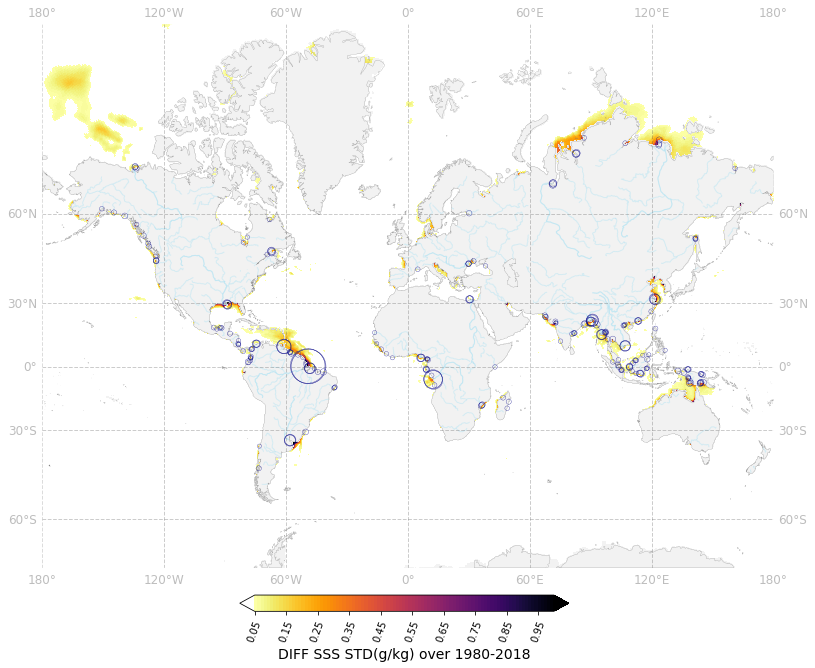

In [23]:
## REGION TO PLOT
#reg='atl'
reg='GLO'

iexp='DIFF' 
# PLOT NAME

if iexp=='DIFF':
    namo = "JZmapSPH"+reg+"_SSSdt_STD_RNF-"+qth+"_"+fo+"_"+iexp+"_"+nexp+"-"+nexpREF+"_"+y1+"-"+y2

#========= DATA TO PLOT

# main variable
if iexp=='DIFF':
    data2plot  = STDsss1y_dt - STDsss1y_ref_dt
    data2plot  = data2plot.where(tmask!=0,0).squeeze()   

# lat lon
lon2plot   = nav_lon.squeeze()
lat2plot   = nav_lat.squeeze()
# land mask from model
m2plt      = tmask.where(tmask==0)


#========= Plot settings ===============
if iexp=='DIFF':
    #levbounds=[0.1,1.51,0.01]
    levbounds=[0.05,1.01,0.01]
    co='in'
else:
    levbounds=[0.1,1.01,0.01]
    co='sp' #


#add indication of colormap to the plot name:
namo = co+namo

# rgb color for model land grid points
r=242;g=242;b=242

# color for continents from data based (hi-res)
onecohrml='w'

# customed colormapls
if (co=='in'):
    cmap,norm = slx.mycolormap(levbounds,cm_base='inferno_r',cu='w',co='k')

# set grid params for future fig
gridl,incrgridlon,incrgridlat,sath,minlat,maxlat,minlon,maxlon,loncentr,latcentr = slx.pltgridparam(reg=reg,gridl=False)


#================================================================
#========= CREATE FIGURE
fig3 = plt.figure(figsize=([18,10]),facecolor='white')

#========= PLOT DATA
# Data system proj (if coords are in lat lon, use PlateCarre here)
trdata  = ccrs.PlateCarree() 

if (reg=='GLO'):
    ax = plt.axes(projection= ccrs.Mercator(central_longitude=loncentr,min_latitude=minlat, max_latitude=maxlat, globe=None))
else:
    ax = plt.axes(projection= ccrs.NearsidePerspective(central_longitude=loncentr, central_latitude=latcentr,satellite_height=sath))

cs  = plt.pcolormesh(lon2plot, lat2plot, data2plot,shading='flat',cmap=cmap,transform=trdata,norm=norm)

# add grey shading  where ocean mask is 0 (land gridpoints in the model)
# rgb color for model land grid points
cs2  = plt.pcolormesh(lon2plot, lat2plot, m2plt, shading='flat',cmap=slx.make_SLXcolormap(reverse=False,whichco='oneco',r=r,g=g,b=b),transform=trdata)

#========= GEOGRAPHICAL FEATURES
# make plot nice with rivers, continents, grids:
ax,gl = slx.pltaddfeatures(ax,incrgridlon,incrgridlat,onecohrml='none',reg=reg,landedgeco='#6E6E6E')  ##585858#BDBDBD

#========= ADD CIRCLES FOR LARGER ANNUAL RUNOFFS VALUES (gridpoints)
s1=plt.scatter(x=lonselect.values,
    y=latselect.values,
    alpha=1,
    s=magnitude*1200,
    linewidths=0.3,
    marker='o',
    facecolors='none', 
    edgecolors='#08088A',
    transform=trdata,
    cmap='inferno_r',
    zorder=20) 

#========= ADD COLORBAR
cbon=True
if cbon:
        tlabel=iexp+" SSS STD(g/kg) over "+y1+"-"+y2
        cb = slx.addcolorbar(fig3,cs,ax,levbounds,levincr=10,tformat="%.2f",
                             tlabel=tlabel,facmul=1,orientation='horizontal',tc='k',
                            bbta=(-0.18,-0.25,0.9,0.2))  
        
#========= PLT SHOW AND SAVE
plt.show()

# Save fig in png, resolution dpi    
slx.saveplt(fig3,diro,namo,dpifig=500)
plt.close(fig3)

# Trend of the yearly timeseries of runoffs

As an illustration, runoff timeseries at the amazon mouth:

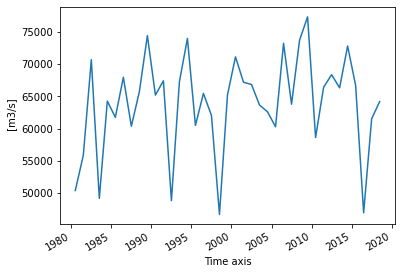

In [24]:
rnf1y_c.isel(x=952,y=684).plot()

* compute trend of runoffs

In [25]:
# compute linear trend
xrtrrnf,xrorigins,years = slx.trpolyfit(rnf1y_c)


# retrieve trend  timeseries
rnf1y_c_tr = slx.trseries(xrtrrnf,xrorigins,years,rnf1y_c.time_counter)


# retrieve detrended timeseries
rnf1y_c_dt = rnf1y_c - rnf1y_c_tr


# quick and dirty check plot

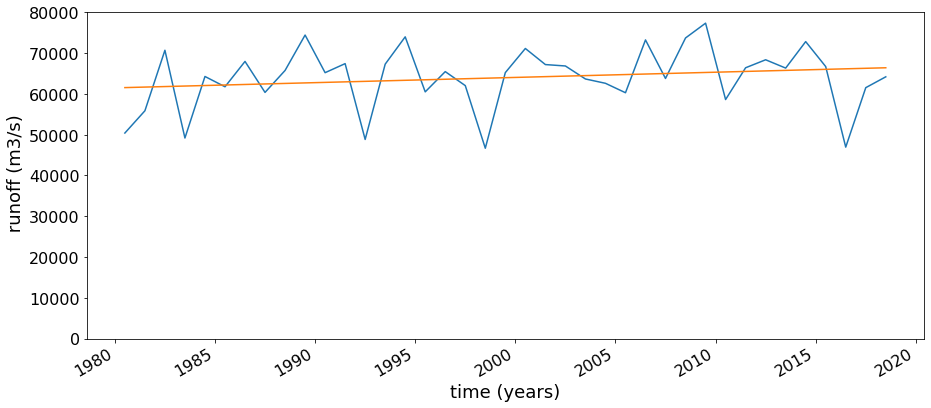

In [27]:
fig1 = plt.figure(figsize=([15,6]),facecolor='white')

rnf1y_c.isel(x=952,y=684).plot()
rnf1y_c_tr.isel(x=952,y=684).plot()

tsize=18
plt.xlabel( 'time (years)',size=tsize)
plt.ylabel(' runoff (m3/s)',size=tsize)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim(0,80000)
plt.show()

## Sort out runoff trends

In [29]:
xrtrends_stack= xrtrrnf.stack(z=("x", "y"))
xtrend_stack_abs= abs(xrtrends_stack)

#quantile 95% high values
tr90p = xrtrends_stack.quantile(0.90,dim='z')
tr90n = xrtrends_stack.quantile(0.10,dim='z')
tr90abs = xtrend_stack_abs.quantile(0.95,dim='z')
print(tr90p.values)
print(tr90n.values)

0.9660871326205024
-0.5363568026472377


## select 10% largest positive and negative runoff trends

In [31]:
#rntrposiselect = xrtrends_stack.where(((rnf1y_1YAVE_stack>threshold)&(xrtrends_stack>0.)),drop=True)
rntrposiselect = xrtrends_stack.where(((xrtrends_stack>tr90p)&((xrtrends_stack>0.))),drop=True)
latselecttrp = nav_lat_stack.where(((xrtrends_stack>tr90p)&((xrtrends_stack>0.))),drop=True)
lonselecttrp = nav_lon_stack.where(((xrtrends_stack>tr90p)&((xrtrends_stack>0.))),drop=True)

rntrnegaselect = xrtrends_stack.where(((xrtrends_stack<tr90n)&((xrtrends_stack<0.))),drop=True)
latselecttrn = nav_lat_stack.where(((xrtrends_stack<tr90n)&((xrtrends_stack<0.))),drop=True)
lonselecttrn = nav_lon_stack.where(((xrtrends_stack<tr90n)&((xrtrends_stack<0.))),drop=True)

# for plot purposes, shift lon lat so that they are in the center of the gridpoint instead of on left side
latselecttrp = latselecttrp+0.125
lonselecttrp = lonselecttrp+0.125
latselecttrn = latselecttrn+0.125
lonselecttrn = lonselecttrn+0.125

# set magnitude for latter plot (magnitude relative to max runoff)
magnitudetrp = (rntrposiselect.values)/(rntrposiselect.max().values)
magnitudetrn = (rntrnegaselect.values)/(-1.*rntrposiselect.max().values)

# plot on top of SS STD diff

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


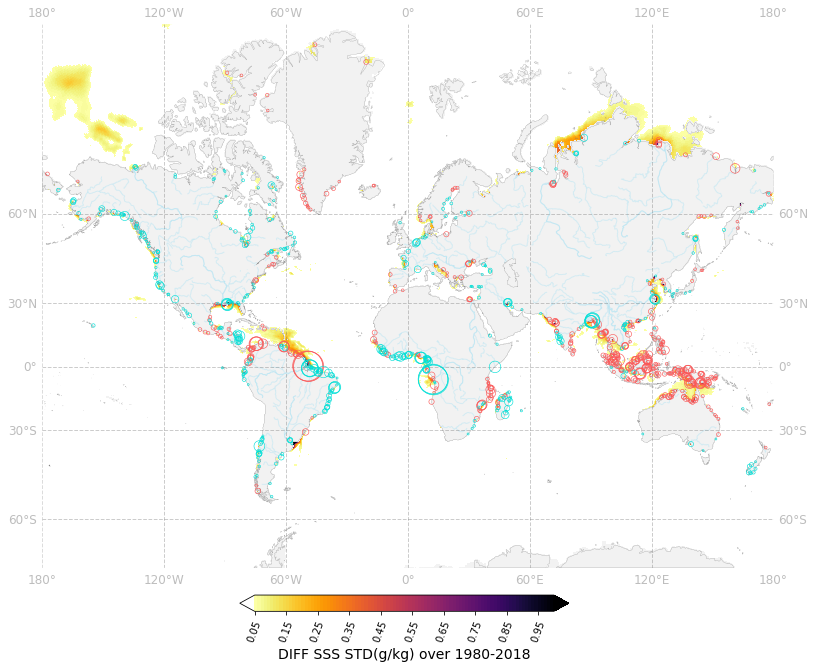

In [32]:
## REGION TO PLOT
#reg='atl'
reg='GLO'

iexp='DIFF' 
# PLOT NAME

if iexp=='DIFF':
    namo = "JZmapSPH"+reg+"_SSSdt_STD_RNFTR-"+qth+"_"+fo+"_"+iexp+"_"+nexp+"-"+nexpREF+"_"+y1+"-"+y2

#========= DATA TO PLOT

# main variable
if iexp=='DIFF':
    data2plot  = STDsss1y_dt - STDsss1y_ref_dt
    data2plot  = data2plot.where(tmask!=0,0).squeeze()   


# lat lon
lon2plot   = nav_lon.squeeze()
lat2plot   = nav_lat.squeeze()
# land mask from model
m2plt      = tmask.where(tmask==0)



#========= Plot settings ===============
if iexp=='DIFF':
    #levbounds=[0.1,1.51,0.01]
    levbounds=[0.05,1.01,0.01]
    co='in'
else:
    levbounds=[0.1,1.01,0.01]
    co='sp' #


#add indication of colormap to the plot name:
namo = co+namo

# rgb color for model land grid points
r=242;g=242;b=242

# color for continents from data based (hi-res)
onecohrml='w'

# customed colormapls
if (co=='in'):
    cmap,norm = slx.mycolormap(levbounds,cm_base='inferno_r',cu='w',co='k')
if (co=='vi'):
    cmap,norm = slx.mycolormap(levbounds,cm_base='viridis_r',cu='w',co='r')
if (co=='sp'):
    cmap,norm = slx.mycolormap(levbounds,cm_base='RdYlBu_r',cu='#080449',co='#5b2123') ##080449

# set grid params for future fig
gridl,incrgridlon,incrgridlat,sath,minlat,maxlat,minlon,maxlon,loncentr,latcentr = slx.pltgridparam(reg=reg,gridl=False)


#================================================================
#========= CREATE FIGURE
fig3 = plt.figure(figsize=([18,10]),facecolor='white')

#========= PLOT DATA
# Data system proj (if coords are in lat lon, use PlateCarre here)
trdata  = ccrs.PlateCarree() 

if (reg=='GLO'):
    ax = plt.axes(projection= ccrs.Mercator(central_longitude=loncentr,min_latitude=minlat, max_latitude=maxlat, globe=None))
else:
    ax = plt.axes(projection= ccrs.NearsidePerspective(central_longitude=loncentr, central_latitude=latcentr,satellite_height=sath))

cs  = plt.pcolormesh(lon2plot, lat2plot, data2plot,shading='flat',cmap=cmap,transform=trdata,norm=norm)

# add grey shading  where ocean mask is 0 (land gridpoints in the model)
# rgb color for model land grid points
cs2  = plt.pcolormesh(lon2plot, lat2plot, m2plt, shading='flat',cmap=slx.make_SLXcolormap(reverse=False,whichco='oneco',r=r,g=g,b=b),transform=trdata)

#========= GEOGRAPHICAL FEATURES
# make plot nice with rivers, continents, grids:
ax,gl = slx.pltaddfeatures(ax,incrgridlon,incrgridlat,onecohrml='none',reg=reg,landedgeco='#6E6E6E')  ##585858#BDBDBD

#========= ADD CIRCLES FOR LARGER ANNUAL RUNOFFS VALUES (gridpoints)
#s1=plt.scatter(x=lonselect.values,
#    y=latselect.values,
#    alpha=1,
#    s=magnitude*800,
#    linewidths=0.3,
#    marker='o',
#    facecolors='none', 
#    edgecolors='#08088A',
#    transform=trdata,
#    cmap='inferno_r',
#    zorder=20) 

s2=plt.scatter(x=lonselecttrp.values,
    y=latselecttrp.values,
    alpha=1,
    s=magnitudetrp*900,
    linewidths=0.6,
    marker='o',
    facecolors='none', 
    edgecolors='#FA5858',
    transform=trdata,
    cmap='inferno_r',
    zorder=20) 

s2=plt.scatter(x=lonselecttrn.values,
    y=latselecttrn.values,
    alpha=1,
    s=magnitudetrn*900,
    linewidths=0.6,
    marker='o',
    facecolors='none', 
    edgecolors='#01DFD7',
    transform=trdata,
    cmap='inferno_r',
    zorder=20) 


#========= ADD COLORBAR
cbon=True
if cbon:
        tlabel=iexp+" SSS STD(g/kg) over "+y1+"-"+y2
        cb = slx.addcolorbar(fig3,cs,ax,levbounds,levincr=10,tformat="%.2f",
                             tlabel=tlabel,facmul=1,orientation='horizontal',tc='k',
                            bbta=(-0.18,-0.25,0.9,0.2))  
        
#========= PLT SHOW AND SAVE
plt.show()

# Save fig in png, resolution dpi    
slx.saveplt(fig3,diro,namo,dpifig=500)
plt.close(fig3)

# zoom

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


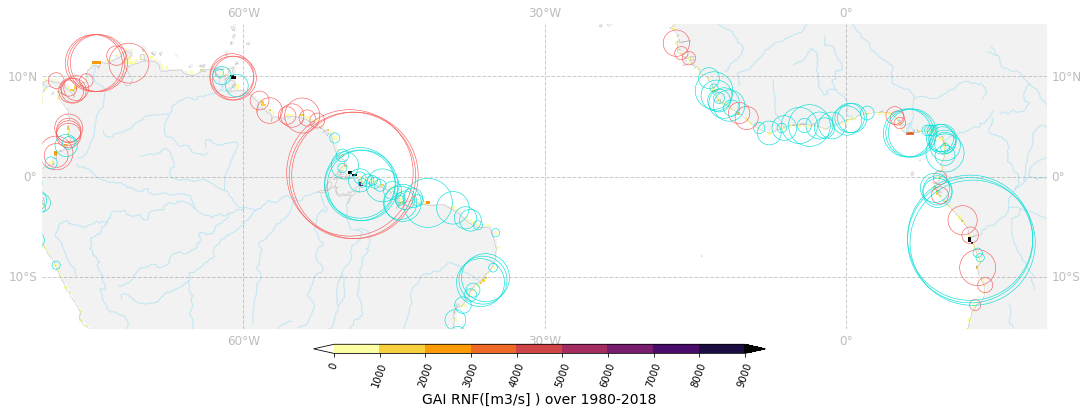

In [45]:
# REGION TO PLOT
reg='GLO'
iexp=nexp

# PLOT NAME
namo = "JZmapZOOM_RNFTR-"+qth+"_Yave_"+fo+"_"+iexp+"_"+y1+"-"+y2

#========= DATA TO PLOT

# main variable
if iexp==nexp:
    data2plot  = rnf1y_1YAVE_c.where(tmask!=0,0).squeeze()
    data2plot=data2plot


# lat lon
lon2plot   = nav_lon.squeeze()
lat2plot   = nav_lat.squeeze()
# land mask from model
m2plt      = tmask.where(tmask==0)
# distance to the coast
#pltdist   = distcoast


#========= Plot settings ===============
levbounds=[0.0,10e3,1e3]

# COLORMAP
co='in' # 
#add indication of colormap to the plot name:
namo = co+namo

# rgb color for model land grid points
r=242;g=242;b=242


# color for continents from data based (hi-res)
#onecohrml='#2E2E2E'
onecohrml='none'


# customed colormapls
if (co=='in'):
    cmap,norm = slx.mycolormap(levbounds,cm_base='inferno_r',cu='w',co='k')

# set grid params for future fig
gridl,incrgridlon,incrgridlat,sath,minlat,maxlat,minlon,maxlon,loncentr,latcentr = slx.pltgridparam(reg=reg,gridl=False)


#================================================================
#========= CREATE FIGURE
fig3 = plt.figure(figsize=([18,10]),facecolor='white')

#========= PLOT DATA
# Data system proj (if coords are in lat lon, use PlateCarre here)
trdata  = ccrs.PlateCarree() 
if (reg=='GLO'):
    ax = plt.axes(projection= ccrs.Mercator(central_longitude=loncentr,min_latitude=minlat, max_latitude=maxlat, globe=None))
else:
    ax = plt.axes(projection= ccrs.NearsidePerspective(central_longitude=loncentr, central_latitude=latcentr,satellite_height=sath))
# plot data
cs  = plt.pcolormesh(lon2plot, lat2plot, data2plot,shading='flat',cmap=cmap,transform=trdata,norm=norm)

# plot grey shading  where ocean mask is 0 (land gridpoints in the model)
# rgb color for model land grid points
cs2  = plt.pcolormesh(lon2plot, lat2plot, m2plt, shading='flat',cmap=slx.make_SLXcolormap(reverse=False,whichco='oneco',r=r,g=g,b=b),transform=trdata)


#========= GEOGRAPHICAL FEATURES
# make plot nice with rivers, continents, grids:
ax,gl = slx.pltaddfeatures(ax,30,10,onecohrml='none',reg=reg,landedgeco='#6E6E6E')  ##585858#BDBDBD


s2=plt.scatter(x=lonselecttrp.values,
    y=latselecttrp.values,
    alpha=1,
    s=magnitudetrp*16000,
    linewidths=0.6,
    marker='o',
    facecolors='none', 
    edgecolors='#FA5858',
    transform=trdata,
    cmap='inferno_r',
    zorder=20) 

s3=plt.scatter(x=lonselecttrn.values,
    y=latselecttrn.values,
    alpha=1,
    s=magnitudetrn*16000,
    linewidths=0.6,
    marker='o',
    facecolors='none', 
    edgecolors='#01DFD7',
    transform=trdata,
    cmap='inferno_r',
    zorder=20) 

ax.set_extent([-80, 20, -10, 10])

#========= ADD COLORBAR
cbon=True
if cbon:
        tlabel=iexp+" RNF([m3/s] ) over "+y1+"-"+y2
        cb = slx.addcolorbar(fig3,cs,ax,levbounds,levincr=1,tformat="%.0f",
                             tlabel=tlabel,facmul=1,orientation='horizontal',tc='k',
                            bbta=(-0.18,-0.25,0.9,0.2))  


#========= PLT SHOW AND SAVE
plt.show()

# Save fig in png, resolution dpi    
slx.saveplt(fig3,diro,namo,dpifig=500)
plt.close(fig3)
    

# Add circles on top of SSS trend diff

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


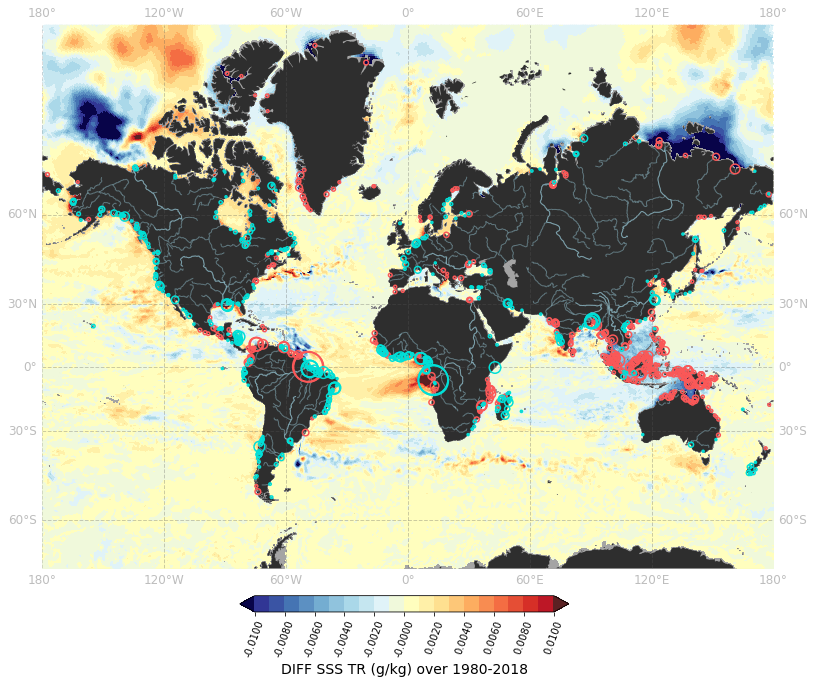

In [33]:
# REGION TO PLOT
reg='GLO'
iexp='DIFF'
#for iexp in ('DIFF',nexp,nexpREF):

# PLOT NAME
namo = "JZmapRNFTR"+reg+"_SSSTR_STD_"+fo+"_"+iexp+"_"+y1+"-"+y2

if iexp=='DIFF':
    namo = "JZmapRNFTR"+reg+"_SSSTR_STD_"+fo+"_"+iexp+"_"+nexp+"-"+nexpREF+"_"+y1+"-"+y2

#========= DATA TO PLOT

# main variable
if iexp==nexp:
    data2plot  = xrtrends.where(tmask!=0,0).squeeze()
if iexp==nexpREF:
    data2plot  = xrtrends_ref.where(tmask!=0,0).squeeze()
if iexp=='DIFF':
    data2plot  = xrtrends-xrtrends_ref
    data2plot  = data2plot.where(tmask!=0,0).squeeze()   


# lat lon
lon2plot   = nav_lon.squeeze()
lat2plot   = nav_lat.squeeze()
# land mask from model
m2plt      = tmask.where(tmask==0)
# distance to the coast
#pltdist   = distcoast


#========= Plot settings ===============
if iexp=='DIFF':
    #levbounds=[0.1,1.51,0.01]
    levbounds=[-0.01,0.011,0.001]
else:
    levbounds=[-0.05,0.051,0.005]



# COLORMAP
co='sp' # 
#add indication of colormap to the plot name:
namo = co+namo

# rgb color for model land grid points
r=164
g=164
b=164

# color for continents from data based (hi-res)
onecohrml='#2E2E2E'


# customed colormapls
if (co=='in'):
    cmap,norm = slx.mycolormap(levbounds,cm_base='inferno_r',cu='w',co='k')
if (co=='vi'):
    cmap,norm = slx.mycolormap(levbounds,cm_base='viridis_r',cu='w',co='r')
if (co=='sp'):
    cmap,norm = slx.mycolormap(levbounds,cm_base='RdYlBu_r',cu='#080449',co='#5b2123')

# set grid params for future fig
gridl,incrgridlon,incrgridlat,sath,minlat,maxlat,minlon,maxlon,loncentr,latcentr = slx.pltgridparam(reg=reg,gridl=False)


#================================================================
#========= CREATE FIGURE
fig3 = plt.figure(figsize=([18,10]),facecolor='white')

#========= PLOT DATA
# Data system proj (if coords are in lat lon, use PlateCarre here)
trdata  = ccrs.PlateCarree() 
if (reg=='GLO'):
    ax = plt.axes(projection= ccrs.Mercator(central_longitude=loncentr,min_latitude=minlat, max_latitude=maxlat, globe=None))
else:
    ax = plt.axes(projection= ccrs.NearsidePerspective(central_longitude=loncentr, central_latitude=latcentr,satellite_height=sath))
# plot data
cs  = plt.pcolormesh(lon2plot, lat2plot, data2plot,shading='flat',cmap=cmap,transform=trdata,norm=norm)

# plot grey shading  where ocean mask is 0 (land gridpoints in the model)
# rgb color for model land grid points
r=164; g=164; b=164;
cs2  = plt.pcolormesh(lon2plot, lat2plot, m2plt, shading='flat',cmap=slx.make_SLXcolormap(reverse=False,whichco='oneco',r=r,g=g,b=b),transform=trdata)

#========= GEOGRAPHICAL FEATURES
# make plot nice with rivers, continents, grids:
ax,gl = slx.pltaddfeatures(ax,incrgridlon,incrgridlat,onecohrml='#2E2E2E',reg=reg)



s2=plt.scatter(x=lonselecttrp.values,
    y=latselecttrp.values,
    alpha=1,
    s=magnitudetrp*900,
    linewidths=1.5,
    marker='o',
    facecolors='none', 
    edgecolors='#FA5858',
    transform=trdata,
    cmap='inferno_r',
    zorder=20) 

s2=plt.scatter(x=lonselecttrn.values,
    y=latselecttrn.values,
    alpha=1,
    s=magnitudetrn*900,
    linewidths=1.5,
    marker='o',
    facecolors='none', 
    edgecolors='#01DFD7',
    transform=trdata,
    cmap='inferno_r',
    zorder=20) 



#========= ADD COLORBAR
cbon=True
if cbon:
        tlabel=iexp+" SSS TR (g/kg) over "+y1+"-"+y2
        cb = slx.addcolorbar(fig3,cs,ax,levbounds,levincr=2,tformat="%.4f",
                             tlabel=tlabel,facmul=1,orientation='horizontal',tc='k',
                            bbta=(-0.18,-0.25,0.9,0.2))  

#========= PLT SHOW AND SAVE
plt.show()

# Save fig in png, resolution dpi    
slx.saveplt(fig3,diro,namo,dpifig=300)
plt.close(fig3)
